<a href="https://colab.research.google.com/github/xtian20/data_project/blob/main/Identifying_Fraudulent_Activities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

from sklearn.metrics import auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

import warnings 
warnings.filterwarnings('ignore')

# Load Datasets

In [2]:
data = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
data.shape

(151112, 11)

In [4]:
address2country = pd.read_csv('IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
address2country.shape

(138846, 3)

In [6]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


## Load Country to Fraud Data

In [7]:
countries = []
for i in range(len(data)):
  ip_address = data.loc[i, 'ip_address']
  tmp = address2country[(address2country['lower_bound_ip_address'] <= ip_address) & (address2country['upper_bound_ip_address'] >= ip_address)]

  if len(tmp) == 1:
    countries.append(tmp['country'].values[0])
  else:
    countries.append('NA')

data['country'] = countries
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


# Feature Engineering 

- Time difference between sign-up time and purchase time. 
- If the device id is unique or certain users are sharing the same device (**many different user ids using the same device could be an indicator of fake accounts**).
- Same for the ip address. **Many different users having the same ip address could be an indicator of  fake accounts**. 
- Usual week of the year and day of week from time variable. 

In [8]:
# get the time difference between purchase time and sign-up time 
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [9]:
# Check user number for unique devices 
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [10]:
# Check user number for unique ip address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [11]:
# Singup day and week 
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week 
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [12]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [13]:
# Define features and target to be used 
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', \
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data1 = data[columns]
data1.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


# Fradulent Activity Identification

## Random Forest Model

In [ ]:
# Initialization H2O cluster 
h2o.init()
h2o.remove_all()

In [15]:
# Transform to H2O frame, and make sure the target variable is categorical 
h2o_df = H2OFrame(data1)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
  h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.501740430938508,,24.658571126052173,36.93537243898567,,,,33.14070358409671,,40942.584427444956,1.6843665625496433,1.6027185134205137,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798854,,11.651556782719474,18.32276214866212,,,,8.617733490961495,,26049.661902118358,2.6169536028041693,2.596239527375835,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


## Train Model

In [16]:
# Split into 70% training and 30# test dataset:
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=20)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target 
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', \
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

In [18]:
# Build Random Forest Model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, stopping_metric='auc', score_each_iteration=True, seed=20)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-01-08 21:31:51,0.093 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-01-08 21:31:54,2.985 sec,1.0,0.312660,0.768713,0.964184,0.948132,1.924870,0.093092,0.261641,1.882658,0.783507,0.476623,7.166937,0.066398
2,,2021-01-08 21:31:56,4.901 sec,2.0,0.319593,0.678704,0.965044,0.953117,1.939674,0.089166,0.213001,0.743440,0.804431,0.642376,10.115690,0.046081
3,,2021-01-08 21:31:58,6.895 sec,3.0,0.315939,0.594035,0.969980,0.960148,1.950740,0.080150,0.207072,0.538686,0.814863,0.669951,10.502406,0.044912
4,,2021-01-08 21:32:00,8.502 sec,4.0,0.316785,0.521665,0.973356,0.965910,1.961844,0.075375,0.204913,0.417641,0.822599,0.682521,10.646031,0.044317
5,,2021-01-08 21:32:01,10.018 sec,5.0,0.316871,0.469928,0.976771,0.970938,1.969894,0.069795,0.204278,0.359374,0.825956,0.687179,10.660158,0.044317
6,,2021-01-08 21:32:03,11.612 sec,6.0,0.315740,0.426058,0.979928,0.975428,1.976657,0.064944,0.203746,0.323820,0.828053,0.690648,10.679152,0.044184
7,,2021-01-08 21:32:04,13.083 sec,7.0,0.312704,0.386928,0.983516,0.979933,1.982001,0.058366,0.203641,0.302937,0.830304,0.693001,10.679152,0.044052
8,,2021-01-08 21:32:06,14.535 sec,8.0,0.316243,0.369066,0.985031,0.982368,1.986268,0.057692,0.203450,0.273569,0.832120,0.695123,10.679152,0.044780
9,,2021-01-08 21:32:07,15.977 sec,9.0,0.313372,0.340736,0.987874,0.985839,1.990083,0.051697,0.203438,0.262452,0.833758,0.696595,10.679152,0.044868


## Feature Importance 

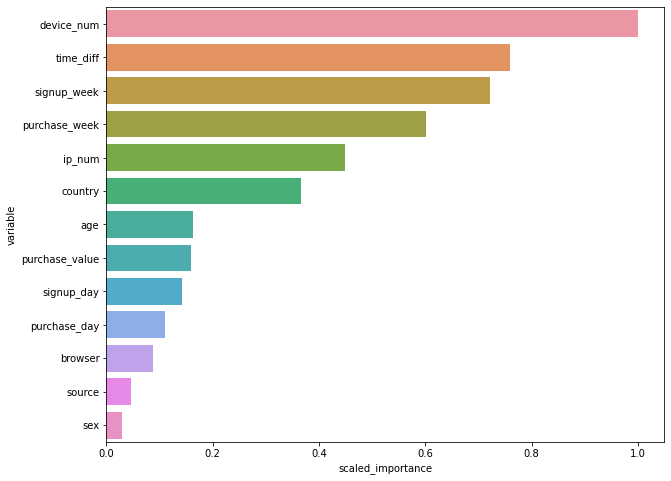

In [20]:
# Feature importance 
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

## Predictions (Confusion Matrix)

In [21]:
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [22]:
# classification report 
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

    accuracy                           0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



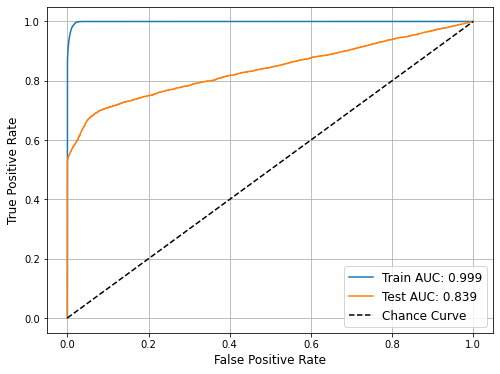

In [23]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: '+str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show();

Based on the ROC, if we care about minimizing false positive rate, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero. (This is the random forest ouput.)

However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as '1': some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up). 

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


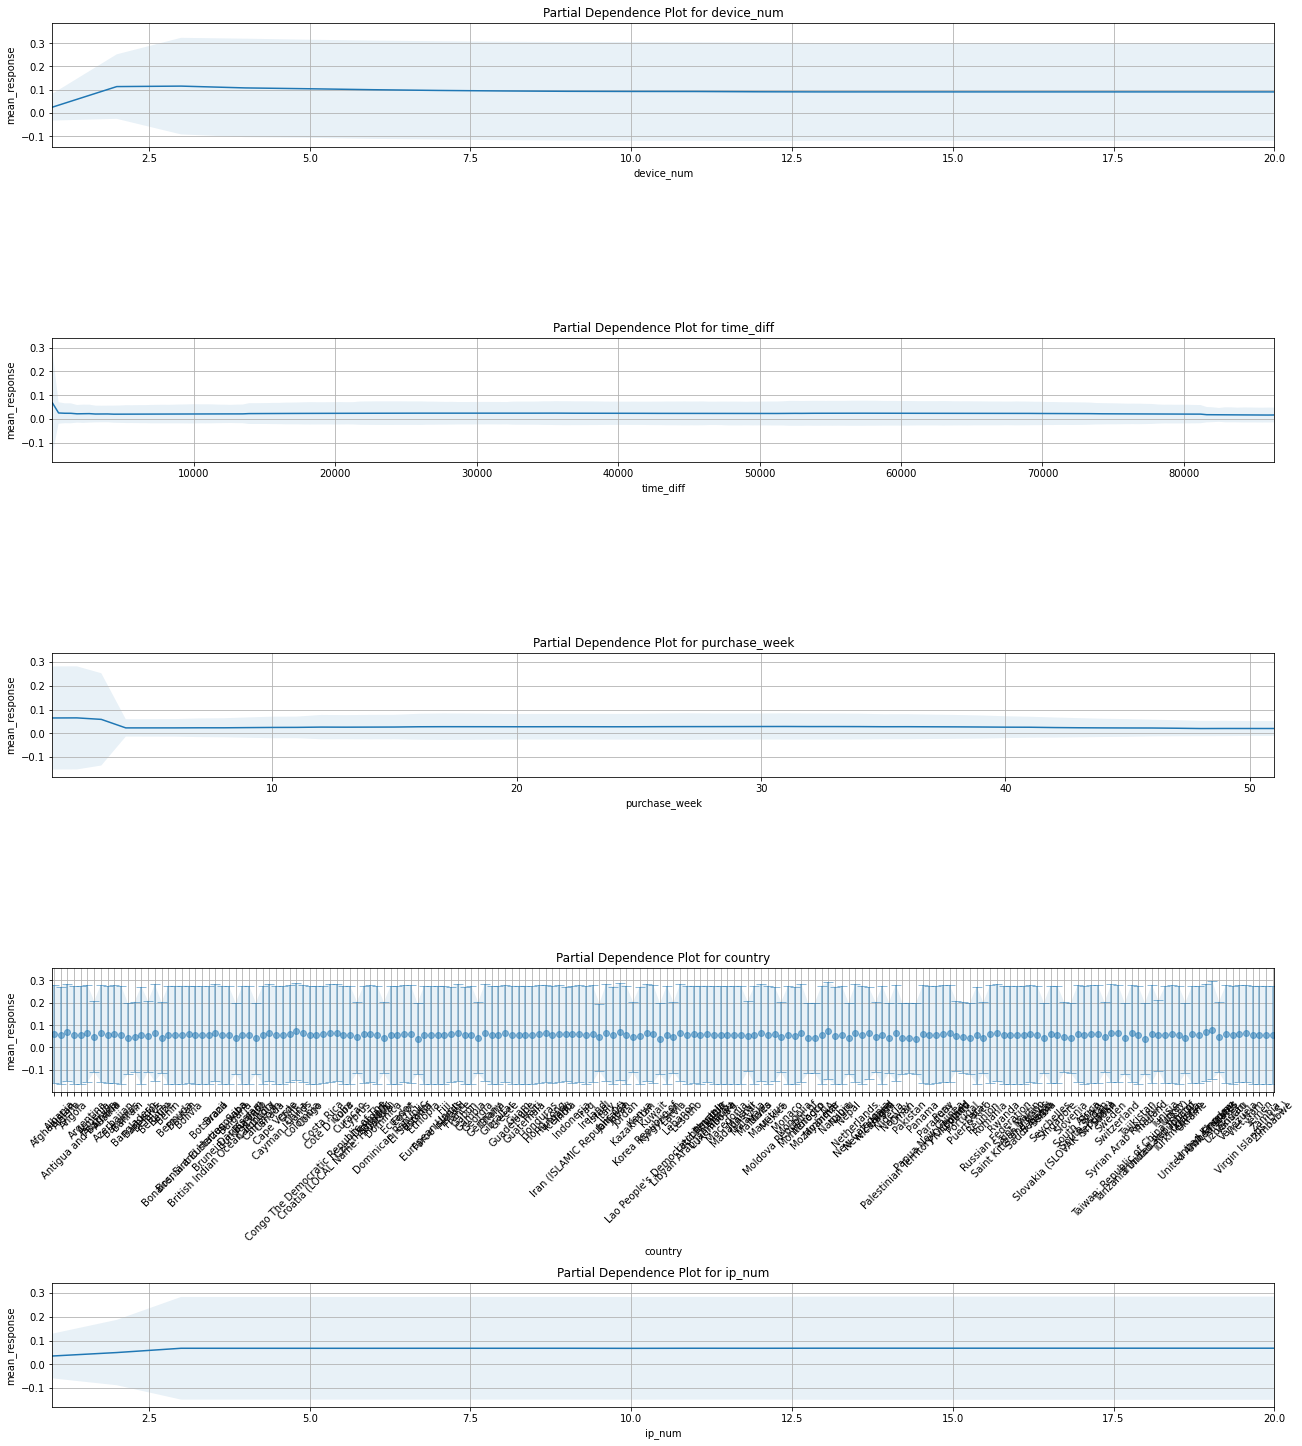

In [24]:
cols = ['device_num', 'time_diff', 'purchase_week', 'country', 'ip_num']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [ ]:
# shutdown h2o instance 
h2o.cluster().shutdown()

# Conclusion 

Product persepctive:

You now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance: 

1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.


This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives).